In [1]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
classes = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}
classes_color = {0: 'blue', 1: 'red', 2: 'green', 3: 'orange', 4: 'purple'}
training_data = pickle.load(open('train.pkl', 'rb'))
training_data = pd.DataFrame(training_data, columns=['sequence', 'composer'])
training_data['composer'] = training_data['composer'].map(classes)
display(training_data)

,sequence,composer
0,"[-1.0, -1.0, -1.0, -1.0, 144.0, 144.0, 144.0, ...",bach
1,"[-1.0, -1.0, 144.0, 144.0, 34.0, 0.0, 4.0, 2.0...",bach
2,"[66.0, 100.0, 148.0, 148.0, 146.0, 64.0, 146.0...",bach
3,"[147.0, 65.0, 64.0, 146.0, 8.0, 50.0, 160.0, 5...",bach
4,"[144.0, 144.0, 144.0, 144.0, 144.0, 64.0, 64.0...",bach
...,...,...
2934,"[144.0, 144.0, 144.0, 66.0, 82.0, 132.0, 8.0, ...",victoria
2935,"[32.0, 33.0, 162.0, 121.0, 68.0, 68.0, 120.0, ...",victoria
2936,"[33.0, 33.0, 33.0, 33.0, 78.0, 2.0, 68.0, 34.0...",victoria
2937,"[96.0, 96.0, 96.0, 96.0, 176.0, 176.0, 176.0, ...",victoria


/tmp/ipykernel_79119/292336954.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(training_data['composer'], ax=ax, palette=classes_color.values())


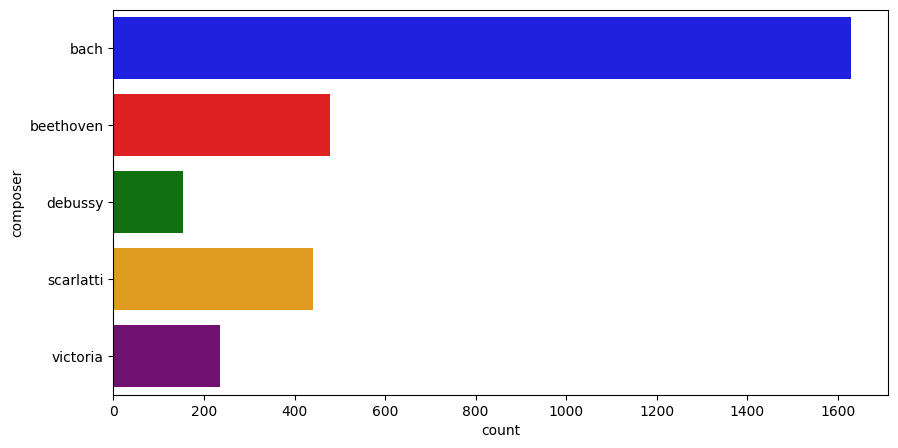

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(training_data['composer'], ax=ax, palette=classes_color.values())
plt.show()

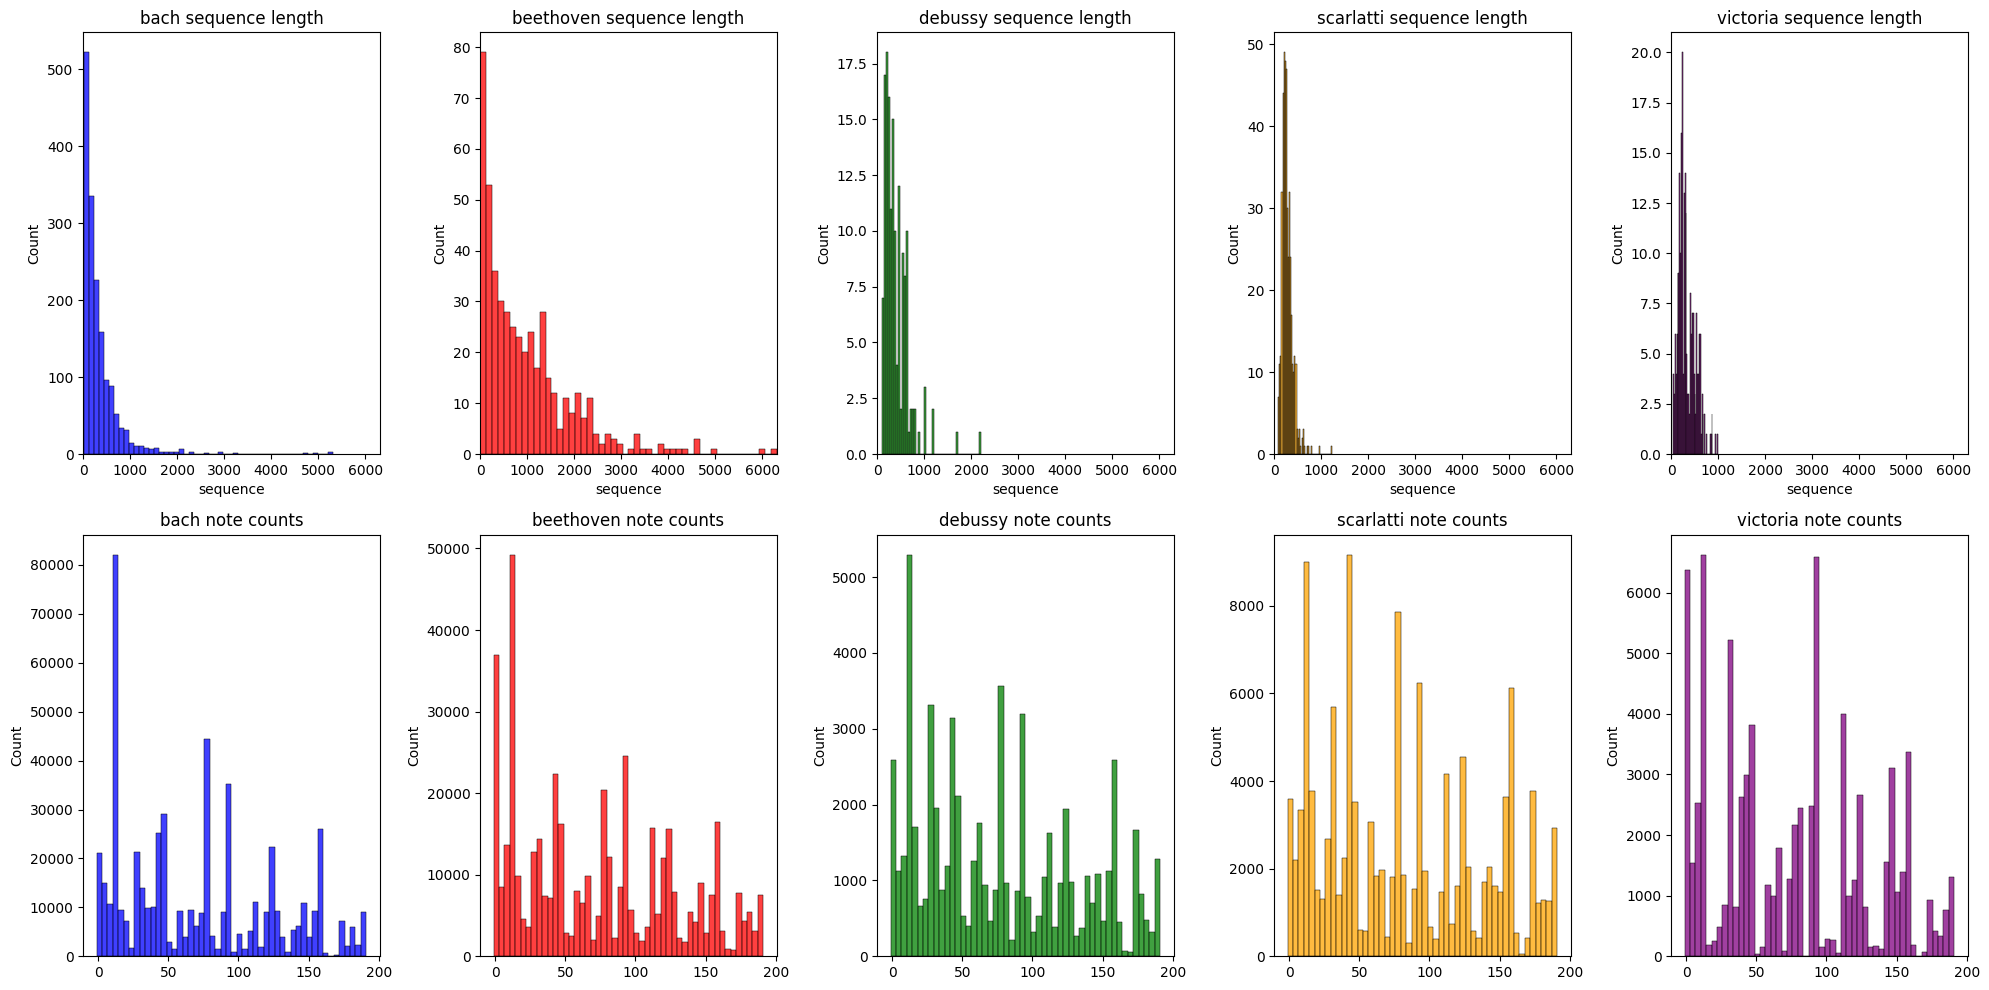

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
max_len = training_data['sequence'].apply(len).max()
for i in range(5):
    c_data = training_data[training_data['composer'] == classes[i]]
    sns.histplot(c_data['sequence'].apply(len), bins=50, ax=ax[0, i], color=classes_color[i])
    ax[0, i].set_title(classes[i] + ' sequence length')
    ax[0, i].set_xlim(0, max_len)
    note_counts = np.array([])
    for seq in c_data['sequence']:
        note_counts = np.concatenate([note_counts, seq])
    sns.histplot(note_counts, bins=50, ax=ax[1, i], color=classes_color[i])
    ax[1, i].set_title(classes[i] + ' note counts')
plt.tight_layout()
plt.show()

## Generowanie nowych danych

In [7]:
def slicing(sequence: list):
    """Take a slice of the sequence."""
    try:
        start_idx = np.random.randint(0, len(sequence))
        end_idx = np.random.randint(start_idx, len(sequence))
        return sequence[start_idx:end_idx]
    except:
        return sequence

def random_erase(sequence: list, p=0.1):
    """Randomly erase some notes."""
    mask = np.random.choice([0, 1], size=len(sequence), p=[p, 1-p])
    return sequence * mask

def random_shift(sequence: list, max_shift=100):
    """Randomly shift the sequence."""
    shift = np.random.randint(-max_shift, max_shift)
    new_sequence = np.roll(sequence, shift)
    return new_sequence

In [17]:
from imblearn.over_sampling import SMOTE
from keras.preprocessing.sequence import pad_sequences

X = pad_sequences(training_data['sequence'].tolist(), padding='post')
y = np.array(training_data['composer'].tolist())

X_resampled, y_resampled = SMOTE().fit_resample(X, y)
# remove the padding
X_resampled = [seq[seq != 0] for seq in X_resampled]
resampled_data = pd.DataFrame({'sequence': X_resampled, 'composer': y_resampled})
display(resampled_data)

,sequence,composer
0,"[-1, -1, -1, -1, 144, 144, 144, 64, 67, 3, 144...",bach
1,"[-1, -1, 144, 144, 34, 4, 2, 65, 144, 146, 32,...",bach
2,"[66, 100, 148, 148, 146, 64, 146, 148, 82, 82,...",bach
3,"[147, 65, 64, 146, 8, 50, 160, 50, 100, 66, 14...",bach
4,"[144, 144, 144, 144, 144, 64, 64, 64, 112, 112...",bach
...,...,...
8145,"[144, 144, 96, 96, 66, 50, 100, 159, 128, 4, 3...",victoria
8146,"[15, 15, 78, 58, 32, 32, 105, 77, 26, 84, 104,...",victoria
8147,"[143, 143, 91, 64, 93, 142, 11, 151, 94, 11, 9...",victoria
8148,"[112, 112, 2, 2, 100, 7, 14, 2, 8, 110, 110, 1...",victoria


In [18]:
funcs = [slicing, random_erase, random_shift]
func_data = pd.DataFrame()
for func in funcs:
    augmented_data = resampled_data.copy()
    augmented_data['sequence'] = augmented_data['sequence'].apply(lambda x: func(x))
    func_data = pd.concat([func_data, augmented_data])
resampled_data = pd.concat([resampled_data, func_data])
display(resampled_data)

,sequence,composer
0,"[-1, -1, -1, -1, 144, 144, 144, 64, 67, 3, 144...",bach
1,"[-1, -1, 144, 144, 34, 4, 2, 65, 144, 146, 32,...",bach
2,"[66, 100, 148, 148, 146, 64, 146, 148, 82, 82,...",bach
3,"[147, 65, 64, 146, 8, 50, 160, 50, 100, 66, 14...",bach
4,"[144, 144, 144, 144, 144, 64, 64, 64, 112, 112...",bach
...,...,...
8145,"[13, 13, 144, 144, 96, 96, 66, 50, 100, 159, 1...",victoria
8146,"[24, 78, 18, 40, 22, 50, 44, 51, 154, 121, 24,...",victoria
8147,"[39, 118, 122, 112, 12, 8, 15, 71, 178, 72, 76...",victoria
8148,"[176, 103, 121, 25, 44, 178, 14, 41, 47, 112, ...",victoria


/tmp/ipykernel_28314/1046278282.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(resampled_data['composer'], ax=ax, palette=classes_color.values())


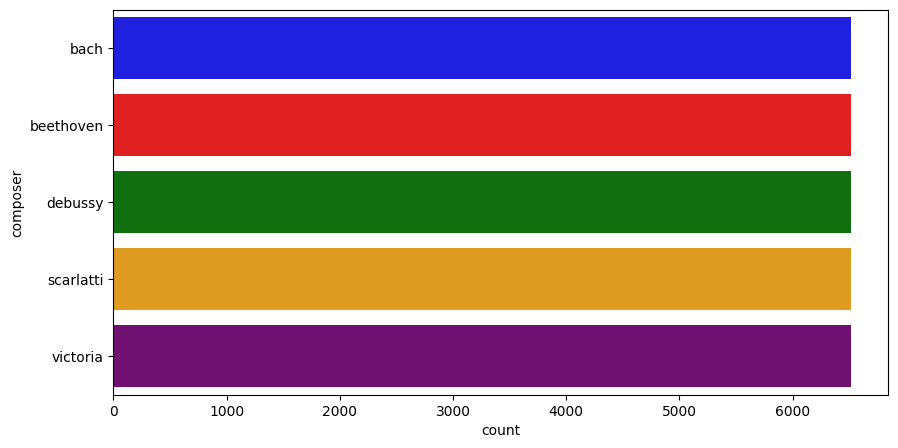

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(resampled_data['composer'], ax=ax, palette=classes_color.values())
plt.show()

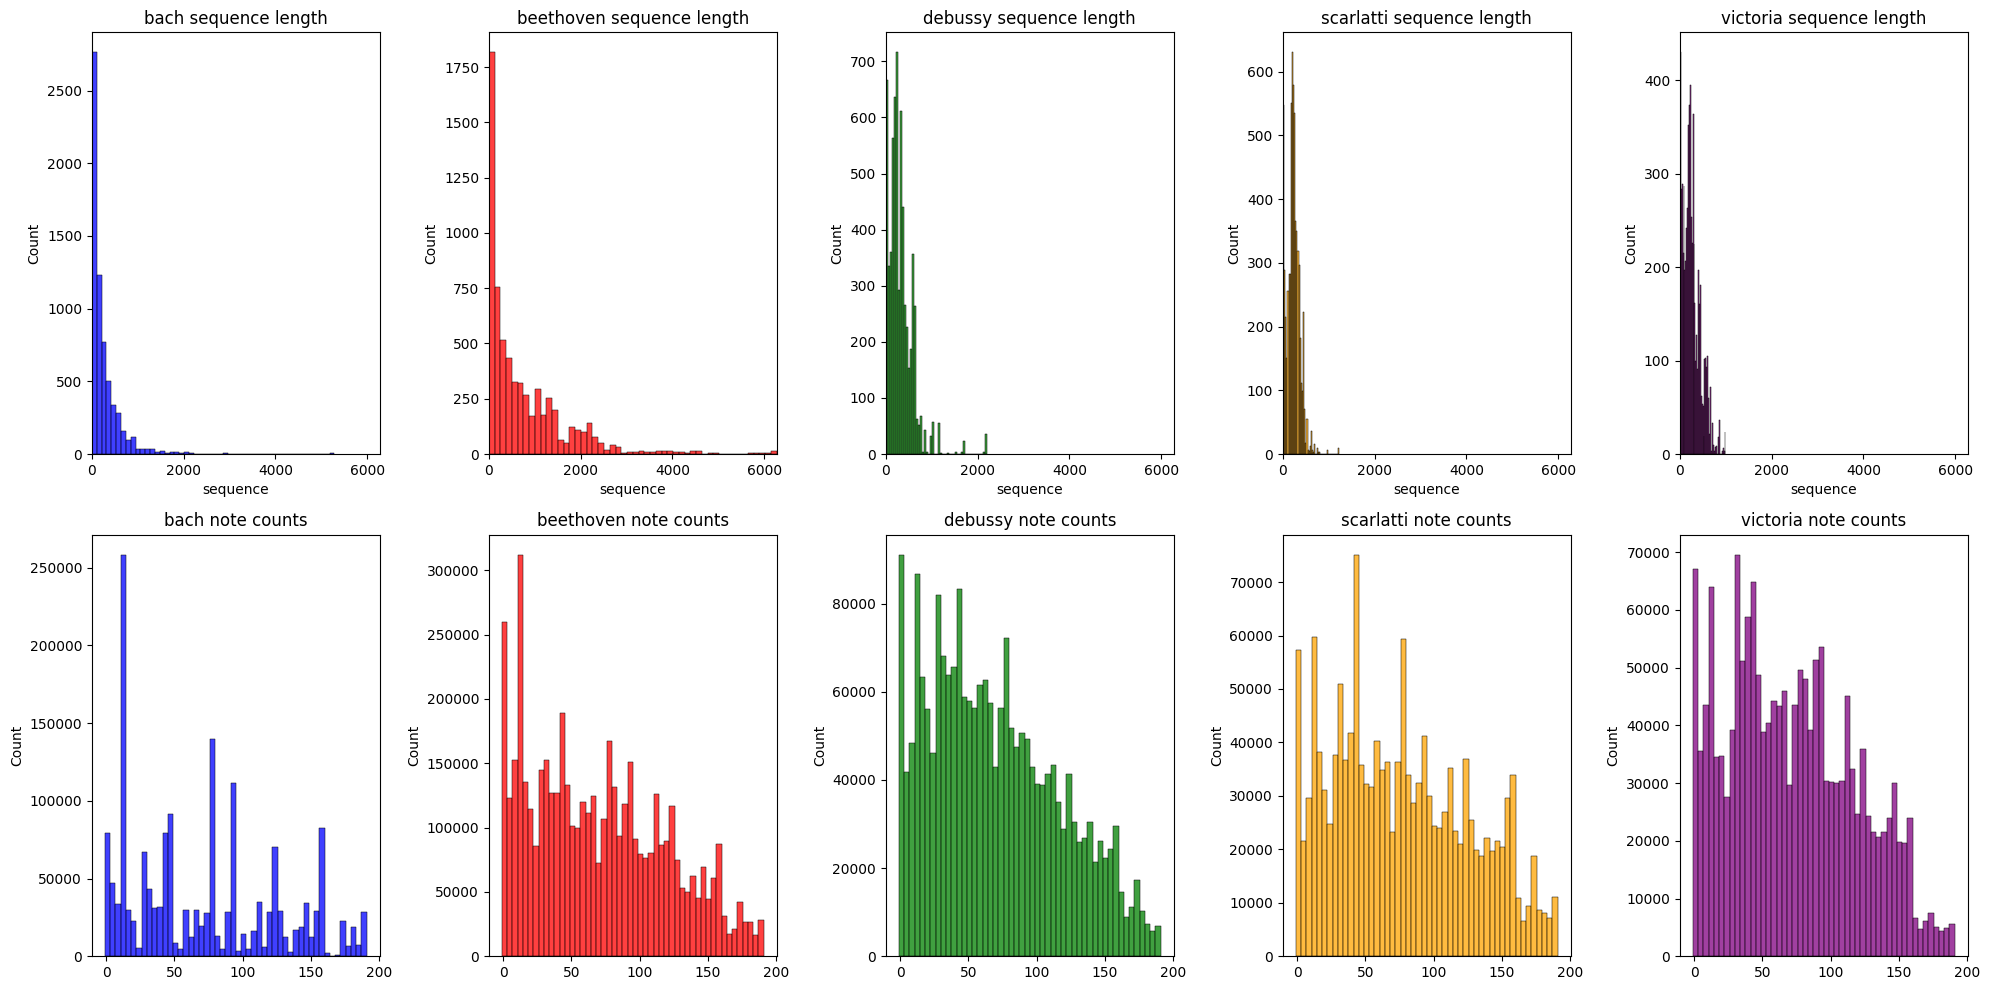

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
max_len = resampled_data['sequence'].apply(len).max()
for i in range(5):
    c_data = resampled_data[resampled_data['composer'] == classes[i]]
    sns.histplot(c_data['sequence'].apply(len), bins=50, ax=ax[0, i], color=classes_color[i])
    ax[0, i].set_title(classes[i] + ' sequence length')
    ax[0, i].set_xlim(0, max_len)
    note_counts = np.array([])
    for seq in c_data['sequence']:
        note_counts = np.concatenate([note_counts, seq])
    sns.histplot(note_counts, bins=50, ax=ax[1, i], color=classes_color[i])
    ax[1, i].set_title(classes[i] + ' note counts')
plt.tight_layout()
plt.show()

## Przekształcanie danych
- Dodanie cech sekwencji
- Nowy model który akceptuje sekwencje plus cechy
- Embedding klas

### Dodanie cech

In [29]:
import numpy as np
from scipy.fft import fft
from scipy.signal import find_peaks

feature_names = ['mean', 'variance', 'standard_deviation', 'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast']

def add_features(seq):
    data = np.array(seq)
    mean = np.mean(data)
    variance = np.var(data)
    standard_deviation = np.std(data)
    fft_vals = fft(data)
    fft_abs = np.abs(fft_vals)
    frequencies = np.linspace(0, len(data), len(data))
    spectral_centroid = np.sum(fft_abs * np.arange(len(data))) / np.sum(fft_abs)
    spectral_bandwidth = np.sum(fft_abs * ((frequencies - spectral_centroid) ** 2)) / np.sum(fft_abs)
    peaks, _ = find_peaks(fft_abs)
    valleys, _ = find_peaks(-fft_abs)
    spectral_contrast = np.mean(fft_abs[peaks]) - np.mean(fft_abs[valleys])
    return np.array([mean, variance, standard_deviation, spectral_centroid, spectral_bandwidth, spectral_contrast])

In [30]:
feat_data = training_data.copy()
feat_data['features'] = feat_data['sequence'].apply(add_features)
for i, name in enumerate(feature_names):
    feat_data[name] = feat_data['features'].apply(lambda x: x[i])
feat_data.drop(columns=['features'], inplace=True)
display(feat_data)

/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_28314/3299588251.py:15: RuntimeWarning: invalid value encountered in scalar divide
  spectral_centroid = np.sum(fft_abs * np.arange(len(data))) / np.sum(fft_abs)


,sequence,composer,mean,variance,standard_deviation,spectral_centroid,spectral_bandwidth,spectral_contrast
0,"[-1.0, -1.0, -1.0, -1.0, 144.0, 144.0, 144.0, ...",bach,73.319176,2854.525545,53.427760,2325.666307,2.055441e+06,2849.963679
1,"[-1.0, -1.0, 144.0, 144.0, 34.0, 0.0, 4.0, 2.0...",bach,75.951710,3090.124876,55.588892,2605.384796,2.623920e+06,3113.599800
2,"[66.0, 100.0, 148.0, 148.0, 146.0, 64.0, 146.0...",bach,70.579392,2867.395724,53.548069,278.294921,3.256554e+04,1084.353610
3,"[147.0, 65.0, 64.0, 146.0, 8.0, 50.0, 160.0, 5...",bach,80.702461,2893.707891,53.793196,206.250639,1.913201e+04,909.729648
4,"[144.0, 144.0, 144.0, 144.0, 144.0, 64.0, 64.0...",bach,73.910473,2744.834890,52.391172,277.473233,3.626537e+04,1000.030255
...,...,...,...,...,...,...,...,...
2934,"[144.0, 144.0, 144.0, 66.0, 82.0, 132.0, 8.0, ...",victoria,83.120438,2846.200823,53.349797,254.451387,3.099356e+04,967.740061
2935,"[32.0, 33.0, 162.0, 121.0, 68.0, 68.0, 120.0, ...",victoria,77.103448,2386.150218,48.848237,76.333811,3.101101e+03,553.218637
2936,"[33.0, 33.0, 33.0, 33.0, 78.0, 2.0, 68.0, 34.0...",victoria,77.445205,2551.137409,50.508785,64.048867,2.277604e+03,356.485762
2937,"[96.0, 96.0, 96.0, 96.0, 176.0, 176.0, 176.0, ...",victoria,78.695035,2851.949550,53.403647,127.890244,8.456511e+03,706.915453


In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(feat_data[feature_names])
y = feat_data['composer']

feat_data = pd.DataFrame(X, columns=feature_names)
feat_data['composer'] = y
display(feat_data)

,mean,variance,standard_deviation,spectral_centroid,spectral_bandwidth,spectral_contrast,composer
0,0.642631,0.517422,0.719320,0.751207,0.525399,0.840611,bach
1,0.665689,0.560127,0.748417,0.841613,0.670711,0.918400,bach
2,0.618634,0.519755,0.720940,0.089495,0.008323,0.319653,bach
3,0.707300,0.524524,0.724240,0.066210,0.004889,0.268129,bach
4,0.647810,0.497539,0.705364,0.089229,0.009269,0.294773,bach
...,...,...,...,...,...,...,...
2934,0.728479,0.515913,0.718271,0.081788,0.007921,0.285245,victoria
2935,0.675777,0.432522,0.657664,0.024221,0.000791,0.162937,victoria
2936,0.678770,0.462429,0.680021,0.020250,0.000581,0.104889,victoria
2937,0.689717,0.516955,0.718996,0.040884,0.002160,0.208286,victoria


## Trenowanie modelu na przekształconych danych

In [45]:
from models import LSTMRegressorFeatures
from training_functions import train_lstm_features
from helper_functions import get_accuracy_features, plot_training, get_confusion_matrix_features, plot_confusion_matrix

In [46]:
def slicing(sequence: list):
    """Take a slice of the sequence."""
    start_idx = np.random.randint(0, len(sequence))
    end_idx = np.random.randint(start_idx, len(sequence))
    return sequence[start_idx:end_idx]


def random_erase(sequence: list, p=0.1):
    """Randomly erase some notes."""
    mask = np.random.choice([0, 1], size=len(sequence), p=[p, 1-p])
    return sequence * mask

def random_shift(sequence: list, max_shift=100):
    """Randomly shift the sequence."""
    shift = np.random.randint(-max_shift, max_shift)
    new_sequence = np.roll(sequence, shift)
    return new_sequence

In [47]:
import numpy as np
from scipy.fft import fft
from scipy.signal import find_peaks

feature_names = ['mean', 'variance', 'standard_deviation', 'spectral_centroid', 'spectral_bandwidth', 'spectral_contrast']

def add_features(seq):
    _data = np.array(seq)
    mean = np.mean(_data)
    variance = np.var(_data)
    standard_deviation = np.std(_data)
    fft_vals = fft(_data)
    fft_abs = np.abs(fft_vals)
    frequencies = np.linspace(0, len(_data), len(_data))
    spectral_centroid = np.sum(fft_abs * np.arange(len(_data))) / np.sum(fft_abs)
    spectral_bandwidth = np.sum(fft_abs * ((frequencies - spectral_centroid) ** 2)) / np.sum(fft_abs)
    peaks, _ = find_peaks(fft_abs)
    valleys, _ = find_peaks(-fft_abs)
    spectral_contrast = np.mean(fft_abs[peaks]) - np.mean(fft_abs[valleys])
    return np.array([mean, variance, standard_deviation, spectral_centroid, spectral_bandwidth, spectral_contrast])

In [101]:
def feature_pipeline(data):
    from sklearn.preprocessing import MinMaxScaler
    
    feat_data = data.copy()
    feat_data['features'] = feat_data['sequence'].apply(add_features)
    for i, name in enumerate(feature_names):
        feat_data[name] = feat_data['features'].apply(lambda x: x[i])
    feat_data.drop(columns=['features'], inplace=True)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(feat_data[feature_names])
    
    ret = pd.DataFrame(X, columns=feature_names)
    ret = pd.concat([ret, data.reset_index(drop=True)], axis=1)

    return ret

In [103]:
def augument_pipeline(data):
    funcs = [slicing, random_erase, random_shift]
    func_data = pd.DataFrame()
    for func in funcs:
        augmented_data = data.copy()
        augmented_data['sequence'] = augmented_data['sequence'].apply(lambda x: func(x))
        func_data = pd.concat([func_data, augmented_data])
    data = pd.concat([data, func_data])
    data = data[data['sequence'].apply(len) > 0]
    data.reset_index(inplace=True, drop=True)
    return data

In [104]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = torch.tensor(self.data.iloc[idx]['sequence'], dtype=torch.float32)
        feat_tensors = [torch.tensor(self.data.iloc[idx][name], dtype=torch.float32) for name in feature_names]
        features = torch.stack(feat_tensors)
        composer = torch.tensor(self.data.iloc[idx]['composer'], dtype=torch.float32)
        return seq, features, composer

In [105]:
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences

data = pickle.load(open('train.pkl', 'rb'))
data = pd.DataFrame(data, columns=['sequence', 'composer'])

max_len = data['sequence'].apply(len).max()
X = pad_sequences(data['sequence'].tolist(), padding='post', maxlen=max_len)
y = np.array(data['composer'].tolist())
data = pd.DataFrame({'sequence': X.tolist(), 'composer': y})

train, val = train_test_split(data, test_size=0.2, stratify=data['composer'])
train = augument_pipeline(train)
train = feature_pipeline(train)
val = feature_pipeline(val)
train.fillna(0, inplace=True)
val.fillna(0, inplace=True)
display(train, val)

/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bruno/OneDrive/homework/studia/SEM4/SSNE/LAB/projekty/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_32916/956652262.py:15: RuntimeWarning: invalid value encountered in scalar divide
  spectral_centroid = np.sum(fft_abs * np.arange(len(_data))) / np.sum(fft_abs)


,mean,variance,standard_deviation,spectral_centroid,spectral_bandwidth,spectral_contrast,sequence,composer
0,0.015497,0.033048,0.181792,0.997983,0.738158,0.158054,"[0, 67, 0, 0, 12, 12, 92, 47, 93, 28, 13, 12, ...",0
1,0.021563,0.050458,0.224629,0.997516,0.738297,0.158062,"[-1, -1, -1, -1, 32, 32, 32, 32, 33, 80, 2, 96...",1
2,0.044569,0.115862,0.340384,0.996338,0.721419,0.250403,"[160, 82, 82, 80, 68, 68, 68, 80, 80, 2, 120, ...",3
3,0.050283,0.109927,0.331553,0.996021,0.731872,0.254407,"[28, 28, 28, 28, 28, 95, 95, 28, 28, 28, 28, 1...",0
4,0.036564,0.089039,0.298394,0.996625,0.703517,0.204830,"[162, 36, 112, 36, 36, 112, 179, 8, 12, 88, 60...",3
...,...,...,...,...,...,...,...,...
9396,0.067399,0.158372,0.397960,0.995099,0.658350,0.339534,"[32, 100, 32, 100, 32, 2, 112, 12, 12, 73, 47,...",0
9397,0.032613,0.075140,0.274116,0.996476,0.808521,0.176130,"[126, 93, 12, 12, 15, 15, 126, 12, 15, 126, 12...",3
9398,0.063209,0.155101,0.393829,0.995282,0.660089,0.307276,"[5, 5, 92, 5, 100, 110, 150, 150, 92, 5, 69, 9...",0
9399,0.061712,0.149186,0.386246,0.995274,0.768485,0.261150,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2


,mean,variance,standard_deviation,spectral_centroid,spectral_bandwidth,spectral_contrast,sequence,composer
0,0.016822,0.028467,0.129150,0.906497,0.395327,0.123028,"[-1, -1, 106, 124, 112, 124, 15, 65, 159, 28, ...",0
1,0.010562,0.017952,0.094694,0.931429,0.550805,0.113707,"[112, 124, 44, 44, 124, 12, 12, 119, 12, 44, 1...",0
2,0.056868,0.102691,0.285178,0.806941,0.140265,0.239938,"[132, 92, 28, 8, 13, 12, 12, 28, 125, 0, 12, 1...",0
3,0.045361,0.078985,0.244213,0.822454,0.286119,0.211986,"[-1, 114, 114, 114, 114, 15, 94, 61, 12, 12, 1...",2
4,0.077387,0.109867,0.296647,0.723615,0.695260,0.266958,"[0, 0, 0, 0, 0, 0, 0, 0, 5, 13, 41, 41, 41, 41...",0
...,...,...,...,...,...,...,...,...
583,0.005995,0.008511,0.055191,0.948026,0.540183,0.086217,"[-1, -1, -1, 0, 92, 47, 12, 0, 13, 93, 92, 47,...",0
584,0.027913,0.045462,0.174296,0.878542,0.151619,0.193522,"[0, 1, 146, 146, 0, 12, 12, 30, 74, 38, 12, 8,...",0
585,0.073549,0.131517,0.329200,0.772879,0.328718,0.294928,"[144, 144, 65, 20, 1, 146, 144, 146, 1, 82, 17...",0
586,0.105849,0.194311,0.411022,0.714149,0.134693,0.365749,"[144, 145, 0, 2, 81, 128, 128, 1, 48, 4, 148, ...",3


In [106]:
from helper_functions import pad_collate_feat

train_dataset = FeatureDataset(train)
val_dataset = FeatureDataset(val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate_feat)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=pad_collate_feat)

In [107]:
model = LSTMRegressorFeatures(max_length=max_len, input_size=1, hidden_size=32, num_layers=2, out_size=5, num_features=len(feature_names), dropout=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)

class_counts = torch.bincount(torch.tensor(train['composer'].values, dtype=torch.long))
class_weights = 1 / class_counts.float()
class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = criterion.to(device)

loss_hist, train_acc, val_acc = train_lstm_features(model, train_loader, val_loader, optimizer, criterion, get_accuracy_features, device=device, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, loss: 1.29


 50%|█████     | 10/20 [02:30<02:29, 14.94s/it]

Epoch: 10, loss: 0.732


100%|██████████| 20/20 [04:59<00:00, 14.99s/it]


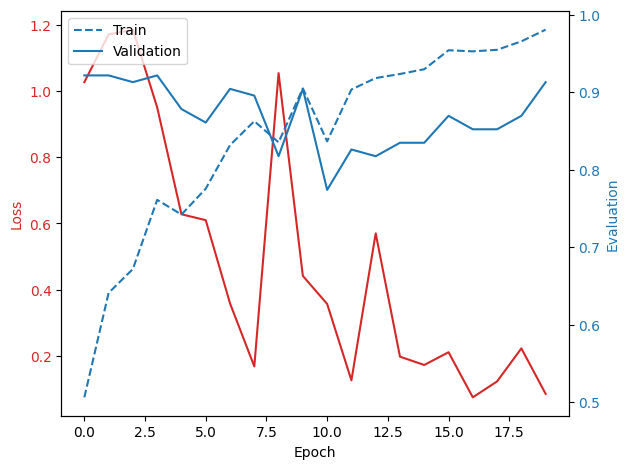

In [12]:
plot_training(loss_hist, train_acc, val_acc)

tensor([[259.,  38.,  11.,  14.,   4.],
        [ 36.,  44.,   2.,   5.,   9.],
        [  7.,   2.,  12.,   7.,   3.],
        [ 24.,   5.,   9.,  49.,   1.],
        [ 11.,   5.,   3.,  10.,  18.]])

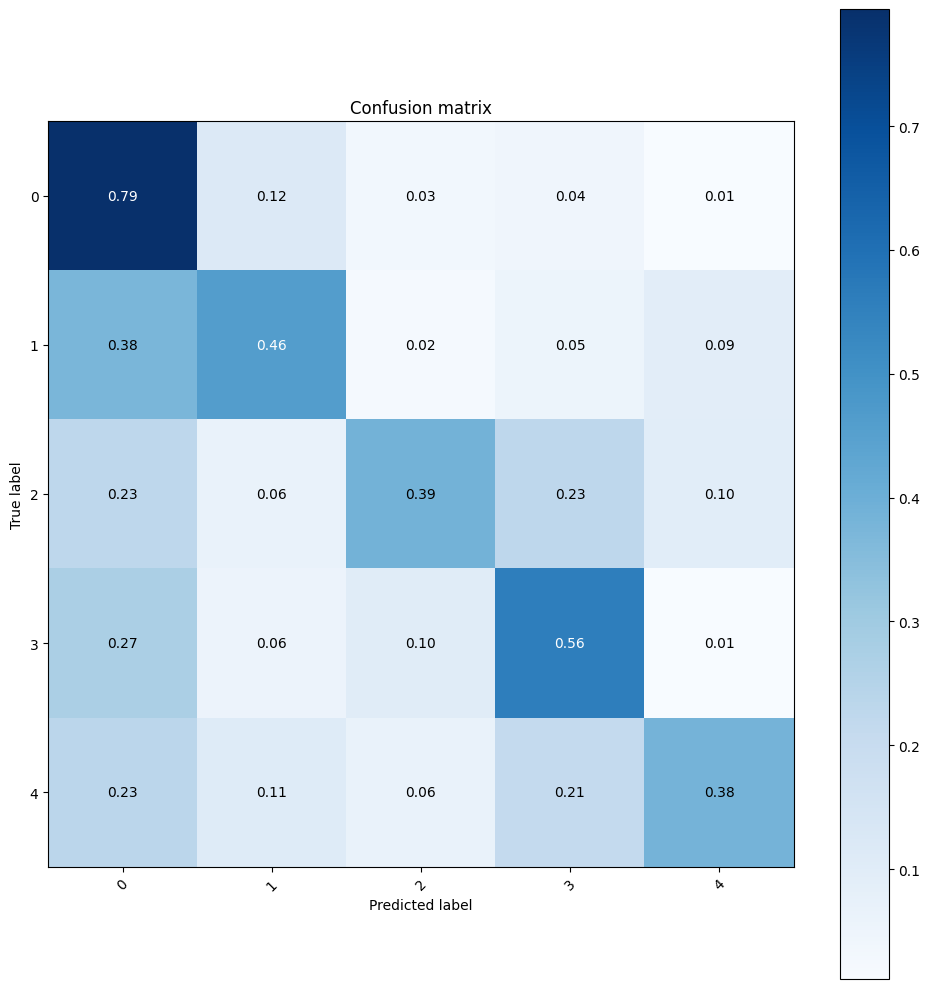

In [108]:
cm = get_confusion_matrix_features(model, val_loader, 5, device)
display(cm)
plot_confusion_matrix(cm, classes)